# kaggle study 33일차(databowl)
코드출처 : https://www.kaggle.com/kmader/nuclei-overview-to-submission

## Overview
이 커널은 아래의 과정을 담고 있습니다.

1. 데이터를 로드하기 위한 사전 처리 단계
2. color-space의 빠른 시각화
3. 간단한 CNN을 교육
4. 검정 데이터에 모형을 적용
5. RLE 테스트 데이터를 생성합니다.

In [1]:
import numpy as np 
import pandas as pd
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data', 'databowl')
stage_label = 'stage1'

## Read in the labels
교육 세트에 대한 RLE 인코딩 출력을 로드합니다.

In [5]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)

,ImageId,EncodedPixels
9456,4e07a653352b30bb95b60ebc6c57afbc7215716224af73...,"[43907, 5, 44931, 7, 45955, 7, 46979, 8, 48003..."
4480,20b20ab049372d184c705acebe7af026d3580f5fd5a72e...,"[417615, 3, 418216, 6, 418819, 7, 419422, 7, 4..."
29075,fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4...,"[235, 13, 490, 14, 745, 14, 1001, 13, 1257, 13..."


## Load in all Images
여기서는 이미지를 로드하고 경로를 처리하여 각 이미지에 적합한 정보를 제공합니다.

In [8]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
17532,C:/Users/이동훈/Desktop/github/kaggle/kagglestudy...,942d56861fc83e195e9c559a000bb86627d8682f8dcc23...,masks,train,stage1
25480,C:/Users/이동훈/Desktop/github/kaggle/kagglestudy...,d4d88391bc399a3715440d4da9f8b7a973e010dc1edd95...,masks,train,stage1


## Create Training Data
여기서는 교육 데이터를 만들고 모든 이미지를 데이터 프레임에 로드합니다. 여기서는 모든 영역을 구분하지 않고 함께 그룹화하여 단순화합니다.

In [42]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 1min 50s


,Stage,ImageId,masks,images
521,stage1,c322c72b9d411e631580fee9312885088b4bb14ed297aa...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[0.01568627450980392, 0.01568627450980392, 0..."


In [43]:
train_img_df['masks'] = train_img_df['masks'].map(lambda x: x.astype('float32'))
train_img_df['images'] = train_img_df['images'].map(lambda x: x.astype('float32'))

## Show a few images
여기서는 단일 분할 알고리즘을 사용하기 어려울 수 있는 밝은 필드와 형광의 혼합이 있는 셀의 몇 가지 이미지를 보여 줍니다.

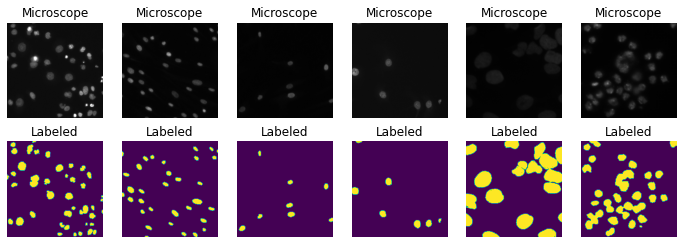

In [10]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

## Look at the intensity distribution
여기서는 강도의 분포를 간략히 살펴보고 몇 개의 그룹이 형성되는 것을 볼 수 있습니다. 각 그룹은 별도로 처리해야 합니다.

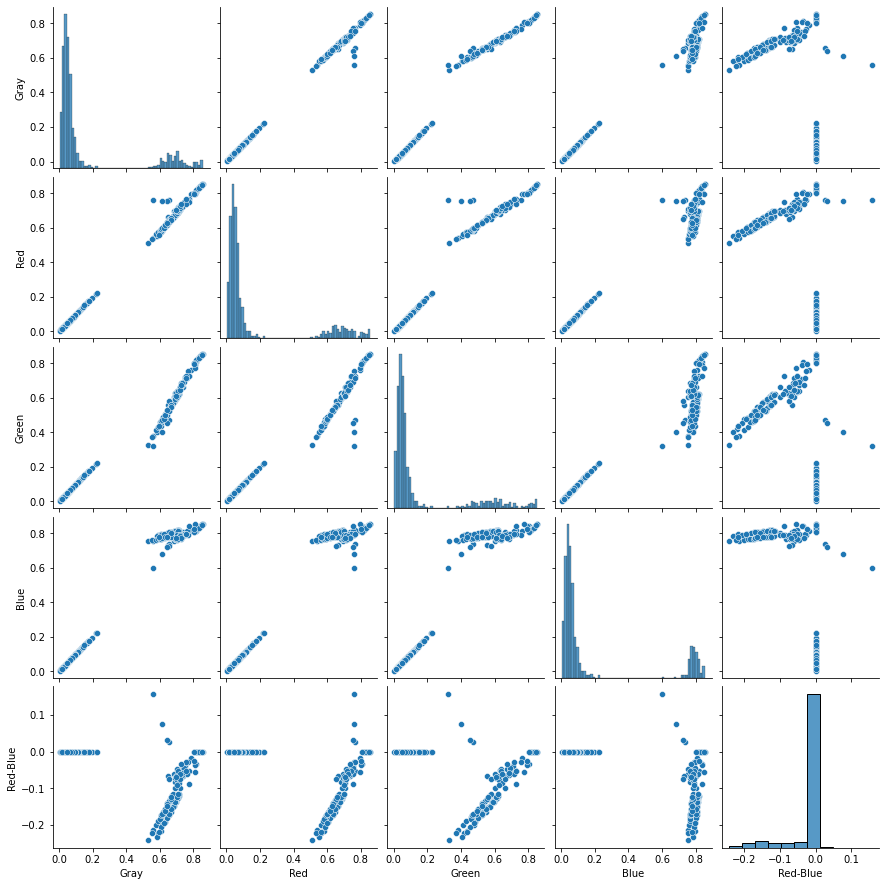

In [11]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]-x[:,:,2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

## Check Dimensions
여기서는 입력 이미지의 다양성을 보기 위한 데이터 치수를 보여 줍니다.

In [44]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64

## Making a simple CNN
여기서는 CNN이 얼마나 잘 동작하는지 간략하게 알아보겠습니다. 이를 위해 배치 정규화를 사용하여 입력을 정규화합니다. 우리는 간단한 문제를 해결하기 위해 패딩으로 조금 속입니다.

In [45]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS), 
                                  name = 'NormalizeInput'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
# 확장을 사용하여 시야를 약간 더 넓힙니다.
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

# 최종 처리
simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
simple_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 16)   

## Loss
결합에 대한 교차로 평가를 받기 때문에 DICE 점수의 역수를 손실 함수로 사용하여 최적화할 수 있습니다.

In [46]:
from keras import backend as K
smooth = 1.

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

simple_cnn.compile(optimizer = 'adam', 
                   #loss = 'mean_squared_error'
                   loss = dice_coef_loss, 
                   metrics=[dice_coef])

## Simple Training
여기서는 간단한 교육을 실시합니다. 각 이미지는 자체 배치(별로 좋지 않음)이지만 코드를 단순하게 유지합니다.

In [47]:
def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

simple_cnn.fit_generator(simple_gen(),steps_per_epoch=train_img_df.shape[0],epochs = 3)

C:\Users\이동훈\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
670/670 [==============================] - 258s 380ms/step - loss: -0.5851 - dice_coef: 0.5851
Epoch 2/3
670/670 [==============================] - 255s 381ms/step - loss: -0.7020 - dice_coef: 0.7020
Epoch 3/3
670/670 [==============================] - 252s 377ms/step - loss: -0.7845 - dice_coef: 0.7845


## Apply Model to Test

In [19]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
Wall time: 1.38 s


,Stage,ImageId,images
39,stage1,7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4...,"[[[0.00784313725490196, 0.00784313725490196, 0..."


In [20]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])

Wall time: 11.7 s


## Show a few predictions

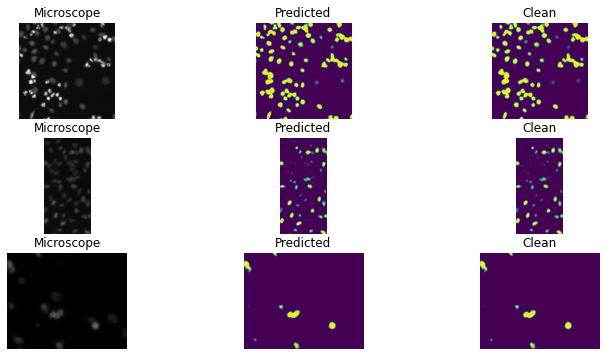

In [21]:
n_img = 3
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))
fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')

## Check RLE
RLE 인코딩(여기의 [코드를 참고](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python))에 대한 접근 방식이 작동하는지 확인합니다.

In [22]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: 숫자 형태의 배열(높이, 너비), 1 - 마스크, 0 - 배경입니다.
    런 길이를 목록으로 반환합니다.
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

## Calculate the RLEs for a Train Image

In [23]:
_, train_rle_row = next(train_img_df.tail(5).iterrows()) 
train_row_rles = list(prob_to_rles(train_rle_row['masks']))

## Take the RLEs from the CSV

In [24]:
tl_rles = train_labels.query('ImageId=="{ImageId}"'.format(**train_rle_row))['EncodedPixels']

## Check
몇 가지 간단한 작업을 수행했기 때문에 모든 것이 완벽하지는 않을 것으로 예상됩니다.

In [25]:
match, mismatch = 0, 0
for img_rle, train_rle in zip(sorted(train_row_rles, key = lambda x: x[0]), 
                             sorted(tl_rles, key = lambda x: x[0])):
    for i_x, i_y in zip(img_rle, train_rle):
        if i_x == i_y:
            match += 1
        else:
            mismatch += 1
print('Matches: %d, Mismatches: %d, Accuracy: %2.1f%%' % (match, mismatch, 100.0*match/(match+mismatch)))

Matches: 360, Mismatches: 0, Accuracy: 100.0%


## Calculate RLE for all the masks
여기서는 모든 마스크에 대한 RLE를 생성하고 결과를 테이블로 출력합니다. 이미지가 매우 흐트러질 수 있기 때문에 몇 가지 형태학적 연산을 사용하여 이미지를 정리합니다(단일 픽셀 제거, 근처 영역 연결 등).

In [26]:
test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [27]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

1383 regions found for 65 images


,ImageId,EncodedPixels
1381,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,49408 1 49658 3 49662 3 49912 9 50168 9 50423 ...
382,43a71aeb641faa18742cb826772a8566c6c947d7050f9a...,17620 1 17876 7 18131 14 18389 18 18647 21 189...
750,78a981bd27ba0c65a9169548665a17bda9f49050d0d389...,40959 6 41475 12 41993 14 42512 16 43031 16 43...


In [28]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)